In [6]:



import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

# Loading the  reduced samples
collisions = pd.read_csv("Motor_Vehicle_Collisions_Crashes.csv", low_memory=False).head(1000)
arrests = pd.read_csv("NYPD_ArrestData.csv", low_memory=False).head(1000)

# Dropping  NaNs in location columns
arrests = arrests.dropna(subset=['Latitude', 'Longitude'])
collisions = collisions.dropna(subset=['BOROUGH'])

# Converting  arrests to GeoDataFrame
geometry = [Point(xy) for xy in zip(arrests['Longitude'], arrests['Latitude'])]
arrests_gdf = gpd.GeoDataFrame(arrests, geometry=geometry, crs='EPSG:4326')

# Rough bounding boxes for boroughs
boroughs_data = {
    "BOROUGH": ["MANHATTAN", "BROOKLYN", "QUEENS", "BRONX", "STATEN ISLAND"],
    "geometry": [
        Polygon([(-74.02, 40.7), (-73.93, 40.7), (-73.93, 40.88), (-74.02, 40.88)]),
        Polygon([(-74.05, 40.65), (-73.85, 40.65), (-73.85, 40.72), (-74.05, 40.72)]),
        Polygon([(-73.95, 40.68), (-73.7, 40.68), (-73.7, 40.8), (-73.95, 40.8)]),
        Polygon([(-73.93, 40.8), (-73.85, 40.8), (-73.85, 40.91), (-73.93, 40.91)]),
        Polygon([(-74.25, 40.5), (-74.05, 40.5), (-74.05, 40.65), (-74.25, 40.65)])
    ]
}
boroughs_gdf = gpd.GeoDataFrame(boroughs_data, crs='EPSG:4326')

# Spatial join to get boroughs in arrests
arrests_mapped = gpd.sjoin(arrests_gdf, boroughs_gdf, how='left', predicate='within')
arrests_mapped = arrests_mapped.drop(columns=['geometry', 'index_right'])

# Join with collision data on borough's and final merged file
merged = pd.merge(collisions, arrests_mapped, on='BOROUGH', how='inner')
merged.to_csv("merged_arrest_collision.csv", index=False)

print(" Merged file :")
print(merged.head())




 Merged file :
   CRASH DATE CRASH TIME   BOROUGH  ZIP CODE  LATITUDE  LONGITUDE  \
0  11-01-2023      01:29  BROOKLYN   11230.0  40.62179 -73.970024   
1  11-01-2023      01:29  BROOKLYN   11230.0  40.62179 -73.970024   
2  11-01-2023      01:29  BROOKLYN   11230.0  40.62179 -73.970024   
3  11-01-2023      01:29  BROOKLYN   11230.0  40.62179 -73.970024   
4  11-01-2023      01:29  BROOKLYN   11230.0  40.62179 -73.970024   

                 LOCATION ON STREET NAME CROSS STREET NAME OFF STREET NAME  \
0  (40.62179, -73.970024)  OCEAN PARKWAY          AVENUE K             NaN   
1  (40.62179, -73.970024)  OCEAN PARKWAY          AVENUE K             NaN   
2  (40.62179, -73.970024)  OCEAN PARKWAY          AVENUE K             NaN   
3  (40.62179, -73.970024)  OCEAN PARKWAY          AVENUE K             NaN   
4  (40.62179, -73.970024)  OCEAN PARKWAY          AVENUE K             NaN   

   ...  ARREST_PRECINCT  JURISDICTION_CODE  AGE_GROUP  PERP_SEX  \
0  ...                5           

In [7]:
# Loading the  datasets
economy_df = pd.read_excel("economy.xlsx")
socio_df = pd.read_excel("socio.xlsx")
# print("economy_df", economy_df.head())
# print("socio_df",socio_df.head())
# Merge on GeoID with suffixes to distinguish overlapping column names
merged_df = pd.merge(socio_df, economy_df, on='GeoID', suffixes=('_socio', '_econ'))

# Drop the  duplicated key columns from the economy dataset
merged_df.drop(columns=['GeoType_econ', 'GeogName_econ'], inplace=True, errors='ignore')

# Renaming the socio dataset to general names
merged_df.rename(columns={
    'GeoType_socio': 'GeoType',
    'GeogName_socio': 'GeogName'
}, inplace=True)

# Reorder to place key identifiers at the front
front_cols = ['GeoType', 'GeogName', 'GeoID']
other_cols = [col for col in merged_df.columns if col not in front_cols]
merged_df = merged_df[front_cols + other_cols]

# Removing the  columns with zero variance
merged_df = merged_df.loc[:, merged_df.nunique() > 1]

# final merged file
merged_df.to_csv("merged_socio_economic.csv", index=False)
merged_df.head()

,GeogName,GeoID,HH1E,HH1M,HH1C,Fam1E,Fam1M,Fam1C,Fam1P,Fam1Z,...,Pv400t499E,Pv400t499M,Pv400t499C,Pv400t499P,Pv400t499Z,Pv500plE,Pv500plM,Pv500plC,Pv500plP,Pv500plZ
0,City Council District 01,1,79496,2419,1.9,35833,1963,3.3,45.1,2.1,...,10744,1168,6.6,6.6,0.7,83570,3536,2.6,51.2,1.5
1,City Council District 02,2,82618,2187,1.6,25974,1553,3.6,31.4,1.7,...,8017,949,7.2,5.2,0.6,80121,3619,2.7,52.4,1.7
2,City Council District 03,3,90007,2137,1.4,25670,1507,3.6,28.5,1.5,...,9587,1104,7.0,6.3,0.7,89782,3444,2.3,59.3,1.6
3,City Council District 04,4,83689,2249,1.6,33572,1735,3.1,40.1,1.8,...,10529,1658,9.6,6.7,1.0,112354,3987,2.2,71.3,1.0
4,City Council District 05,5,84081,2562,1.9,35929,1922,3.3,42.7,1.9,...,9633,1261,8.0,6.1,0.8,105105,4330,2.5,66.2,1.5


In [8]:

# Loading datasets
socio_econ_df = pd.read_csv("merged_socio_economic.csv")
arrest_collision_df = pd.read_csv("merged_arrest_collision.csv")

#  Mapping City Council Districts to Boroughs
district_to_borough = {
    'MANHATTAN': [1, 2, 3, 4, 5, 6, 7, 8, 9],
    'BRONX': [10, 11, 12, 13, 14, 15, 16, 17, 18],
    'QUEENS': [19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
    'BROOKLYN': [31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
    'STATEN ISLAND': [46, 47, 48, 49, 50, 51]
}

district_borough_map = {}
for borough, districts in district_to_borough.items():
    for dist in districts:
        district_borough_map[f"City Council District {dist:02d}"] = borough

socio_econ_df['BOROUGH'] = socio_econ_df['GeogName'].map(district_borough_map)
socio_econ_df = socio_econ_df.dropna(subset=['BOROUGH'])

#  Aggregating socio-economic data by borough
socio_by_borough = socio_econ_df.groupby('BOROUGH').mean(numeric_only=True).reset_index()

# Selecting socio-economic features of interest
keywords = ['Pop', 'Inc', 'Pov', 'HH', 'Fam']
socio_columns = ['BOROUGH'] + [col for col in socio_by_borough.columns if any(k in col for k in keywords)]
socio_features = socio_by_borough[socio_columns].copy()

#  Merging with arrest + collision dataset
final_df = arrest_collision_df.merge(
    socio_features,
    left_on='BOROUGH',
    right_on='BOROUGH',
    how='left'
)

# selecting the  Final column
final_columns = [
    'ARREST_BORO', 'BOROUGH', 'PERP_RACE', 'PERP_SEX', 'AGE_GROUP'
] + [col for col in socio_features.columns if col != 'BOROUGH']

final_dataset = final_df[final_columns].copy()

# Saving to CSV
final_dataset.to_csv("final_merged_crime_socio_dataset.csv", index=False)

# Displaying the  top rows
print(final_dataset.head())


<ipython-input-8-07006ac1403c>:3: DtypeWarning: Columns (21,22,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  arrest_collision_df = pd.read_csv("merged_arrest_collision.csv")


  ARREST_BORO   BOROUGH       PERP_RACE PERP_SEX AGE_GROUP          HH1E  \
0           M  BROOKLYN           BLACK        M     25-44  61467.933333   
1           M  BROOKLYN           BLACK        M     25-44  61467.933333   
2           K  BROOKLYN           BLACK        M     25-44  61467.933333   
3           M  BROOKLYN  WHITE HISPANIC        F       65+  61467.933333   
4           M  BROOKLYN           BLACK        M     45-64  61467.933333   

          HH1M      HH1C    Fam1E   Fam1M  ...    FamBwPvM  FamBwPvC  \
0  1403.466667  1.386667  37046.8  1320.0  ...  641.933333      7.44   
1  1403.466667  1.386667  37046.8  1320.0  ...  641.933333      7.44   
2  1403.466667  1.386667  37046.8  1320.0  ...  641.933333      7.44   
3  1403.466667  1.386667  37046.8  1320.0  ...  641.933333      7.44   
4  1403.466667  1.386667  37046.8  1320.0  ...  641.933333      7.44   

    FamBwPvP  FamBwPvZ       PopPvU1E     PopPvU1M  PopPvU1C       PopPvU2E  \
0  15.033333  1.653333  167691.

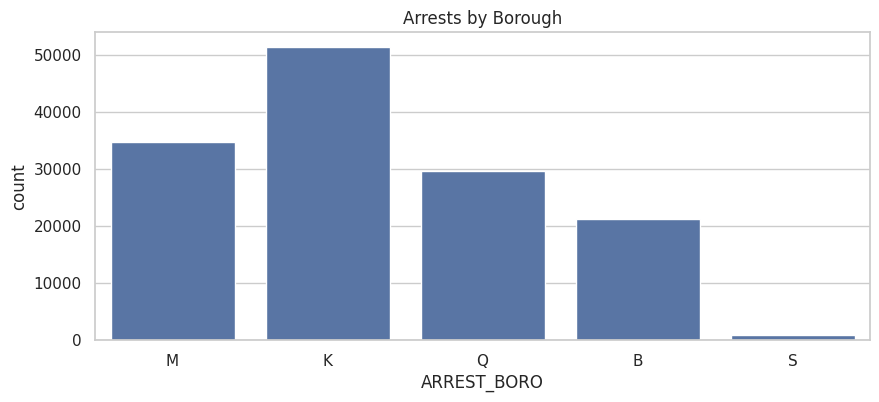

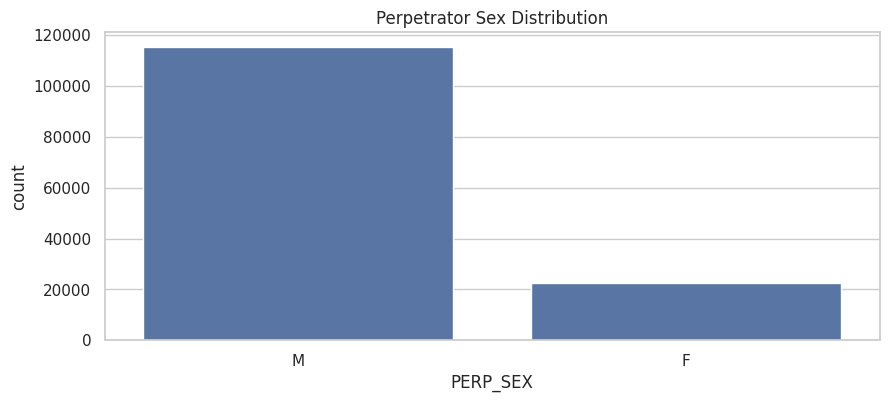

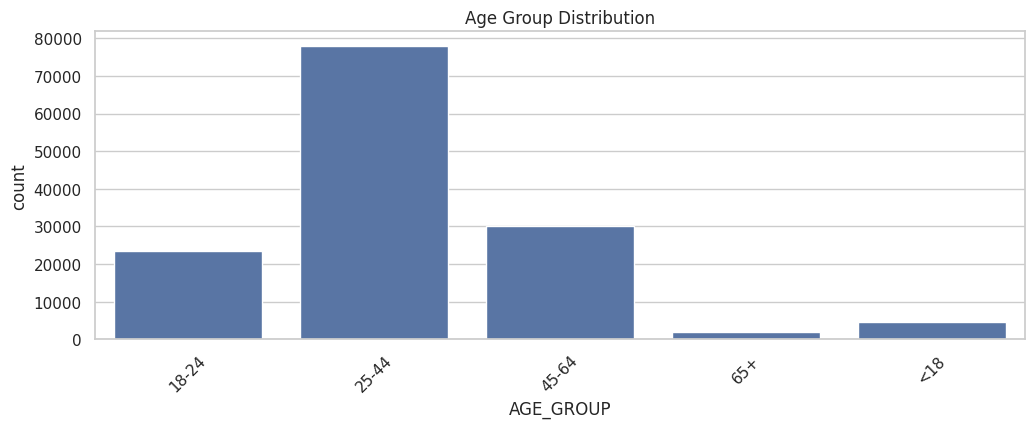

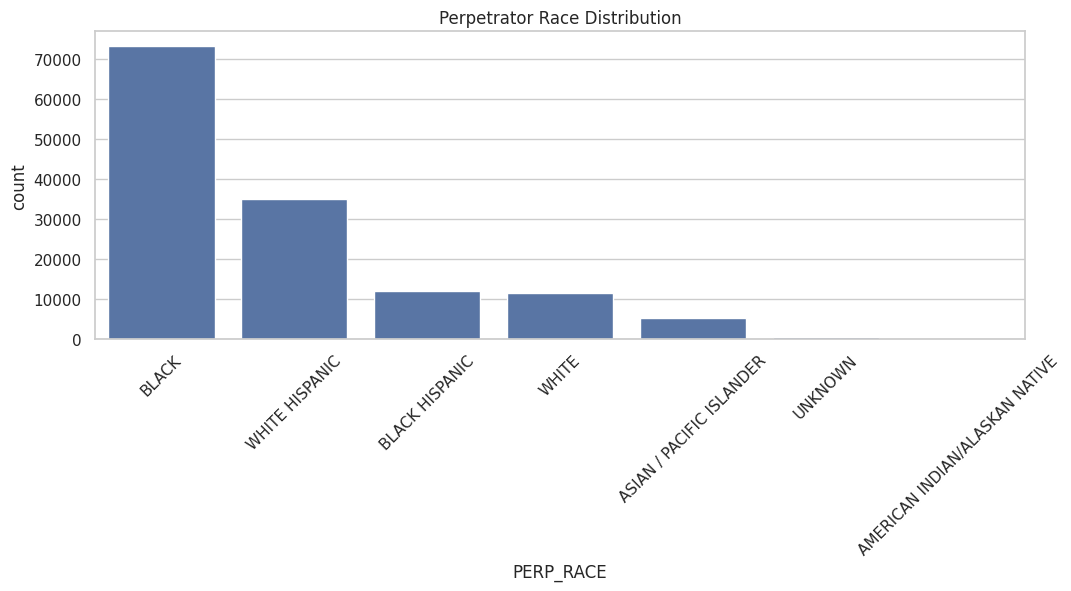

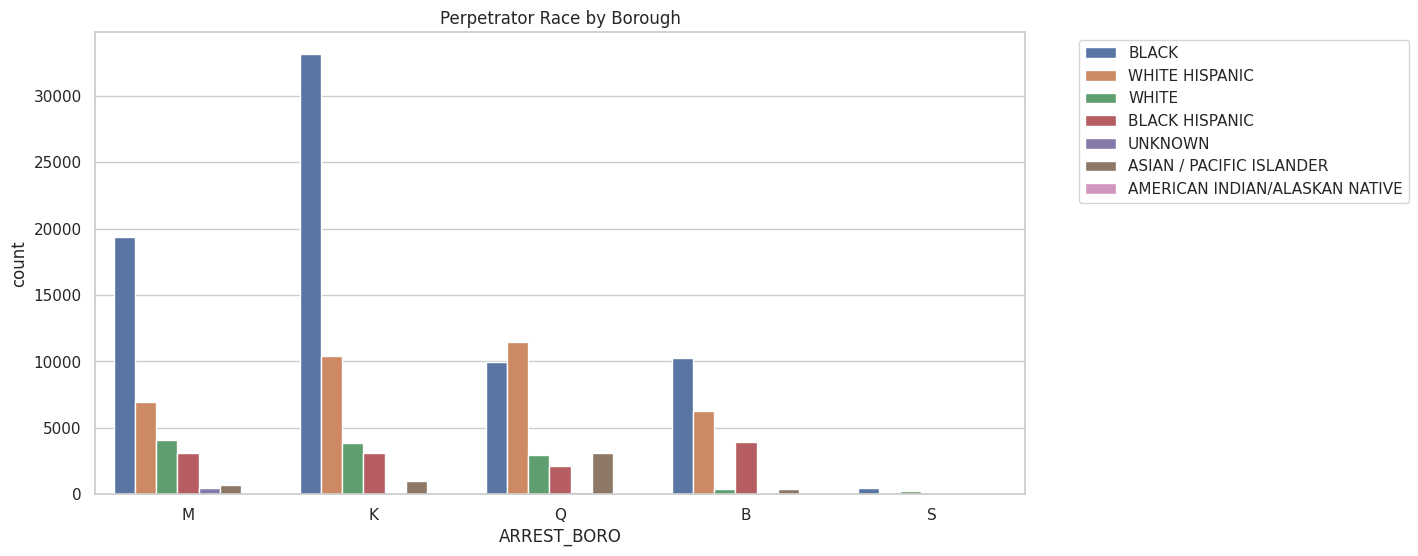

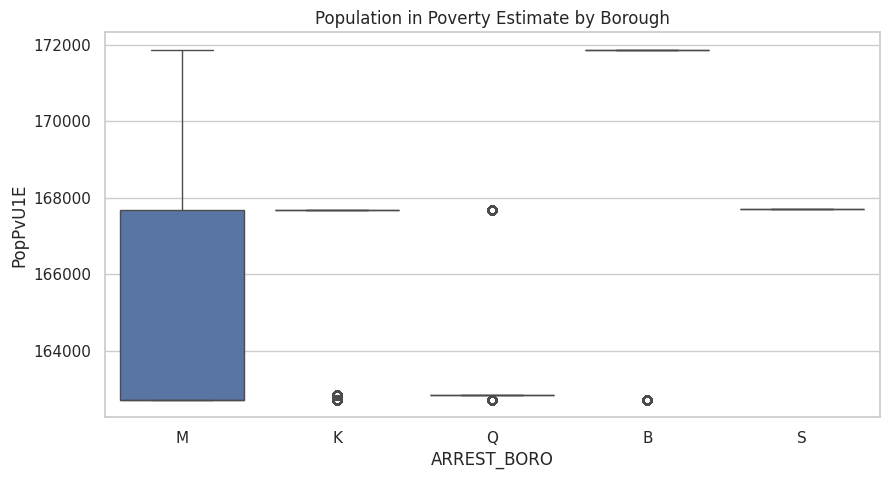

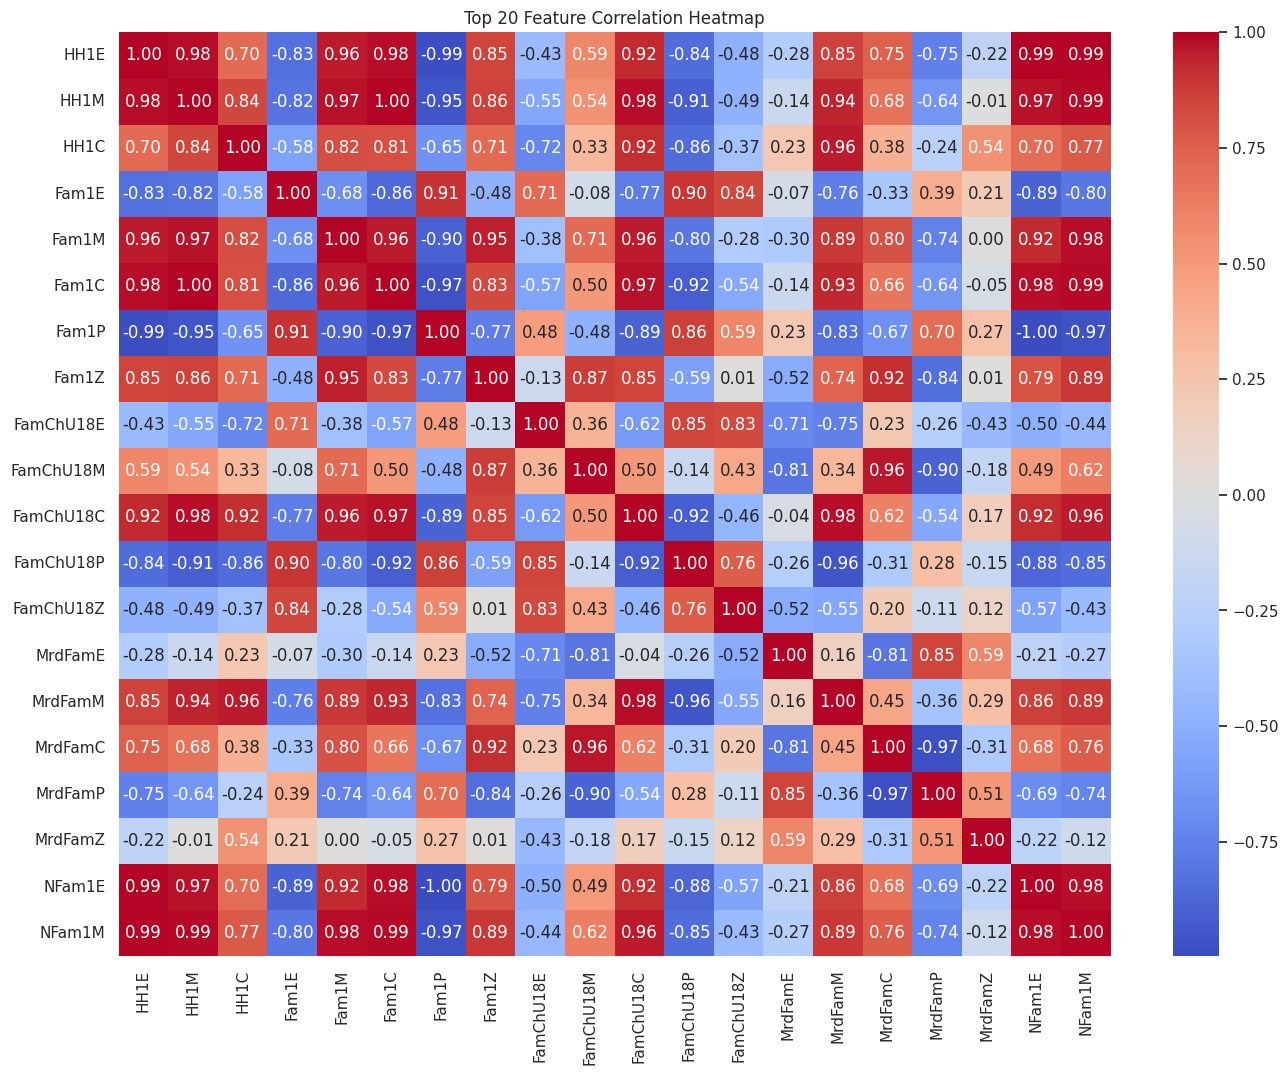

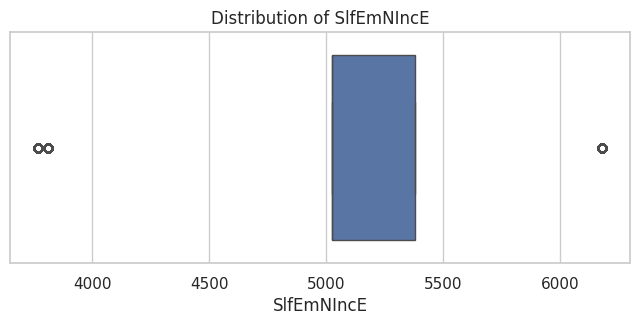

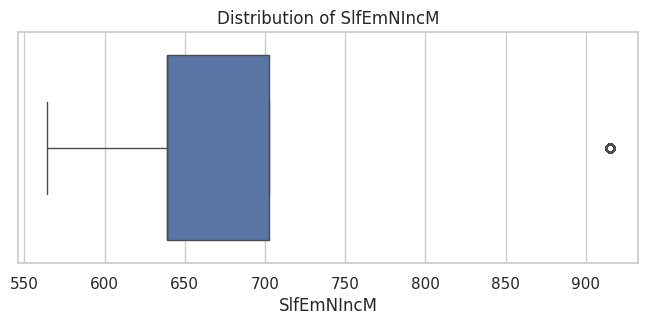

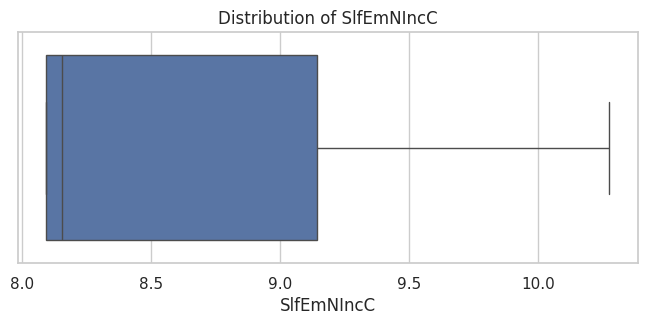

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading  the processed final dataset
df = pd.read_csv("final_merged_crime_socio_dataset.csv")

# visual style
sns.set(style="whitegrid")


plt.figure(figsize=(10, 4))
sns.countplot(x='ARREST_BORO', data=df)
plt.title('Arrests by Borough')
plt.show()

plt.figure(figsize=(10, 4))
sns.countplot(x='PERP_SEX', data=df)
plt.title('Perpetrator Sex Distribution')
plt.show()

plt.figure(figsize=(12, 4))
sns.countplot(x='AGE_GROUP', data=df, order=sorted(df['AGE_GROUP'].unique()))
plt.title('Age Group Distribution')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 4))
sns.countplot(x='PERP_RACE', data=df, order=df['PERP_RACE'].value_counts().index)
plt.title('Perpetrator Race Distribution')
plt.xticks(rotation=45)
plt.show()


# Relationship between ARREST_BORO and PERP_RACE
plt.figure(figsize=(12, 6))
sns.countplot(x='ARREST_BORO', hue='PERP_RACE', data=df)
plt.title('Perpetrator Race by Borough')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Boxplot of Population Estimation by Borough
if 'PopPvU1E' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.boxplot(x='ARREST_BORO', y='PopPvU1E', data=df)
    plt.title('Population in Poverty Estimate by Borough')
    plt.show()

#CORRELATION HEATMAP b/w Socio-economic variables

# Selecting only numerical columns for correlation
numerics = df.select_dtypes(include=['float64', 'int64'])
corr = numerics.corr()

# Plotting top 20 correlated variables
plt.figure(figsize=(16, 12))
sns.heatmap(corr.iloc[:20, :20], annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Top 20 Feature Correlation Heatmap")
plt.show()


# Plot distribution of income-related features
income_cols = [col for col in df.columns if 'Inc' in col]
for col in income_cols[:3]:  # Plot top 3
    if col in df.columns:
        plt.figure(figsize=(8, 3))
        sns.boxplot(x=df[col])
        plt.title(f'Distribution of {col}')
        plt.show()

